In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [82]:
df = pd.read_csv("test.csv")

In [83]:
df= pd.read_csv("data_v3.csv",encoding = "ISO-8859-1")

In [84]:
df

,sentence,report section,stock name,label,year,our_result
0,We serve consumers through our online and phys...,Item 1. Business,AMZN,0,2021,0
1,We are guided by four principles: customer obs...,Item 1. Business,AMZN,0,2021,0
2,"In each of our segments, we serve our primary ...",Item 1. Business,AMZN,0,2021,0
3,"In addition, we provide services, such as adve...",Item 1. Business,AMZN,0,2021,0
4,"We seek to offer our customers low prices, fas...",Item 1. Business,AMZN,0,2021,0
...,...,...,...,...,...,...
502,"Moreover, as additional competitors enter the ...",Item 7. ManagementÕs Discussion and Analysis o...,TSLA,0,2021,1
503,The German Umweltbundesamt has issued our subs...,Item 7. ManagementÕs Discussion and Analysis o...,TSLA,-1,2021,0
504,We are currently focused on ramping production...,Item 7. ManagementÕs Discussion and Analysis o...,TSLA,0,2021,1
505,The Company's management is responsible for th...,Item 8. Financial Statements and Supplementary...,TSLA,0,2021,0


In [70]:
def get_df(df):
    df_array = np.array(df)
    df_list = list(df_array[:,0])
    
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    inputs = tokenizer(df_list, padding = True, truncation = True, return_tensors='pt')
    outputs = model(**inputs)
    
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    model.config.id2label

    
    positive = predictions[:, 0].tolist()
    negative = predictions[:, 1].tolist()
    neutral = predictions[:, 2].tolist()

    table = {'headline':df_list,
             "positive":positive,
             "negative":negative, 
             "neutral":neutral}

    df2 = pd.DataFrame(table, columns = ["headline", "positive", "negative", "neutral"])
    df2['sentiment']=df2[['positive','negative','neutral']].idxmax(axis=1)
    df2['actual']=df['label'].values.tolist()
    df2['same ind'] = (df2['sentiment']==df2['actual']).astype(int)

    return df2

In [71]:
splits=np.array_split(df, 26)
df_total=[]
C=0
for split in splits:
    chunk=get_df(split)
    df_total.append(chunk)
    C=C+1
    print(C,len(splits))
    
df_final=pd.concat(df_total)

1 26
2 26
3 26
4 26
5 26
6 26
7 26
8 26
9 26
10 26
11 26
12 26
13 26
14 26
15 26
16 26
17 26
18 26
19 26
20 26
21 26
22 26
23 26
24 26
25 26
26 26


In [93]:
df_final["sentiment mapped"]=df_final["sentiment"].apply(lambda x: 1 if x=="positive" else (-1 if x=="negative" else 0))
df_final['same ind'] = (df_final['sentiment mapped']==df_final['actual']).astype(int)
df_final["ours"]=df["our_result"]
df_final

,headline,positive,negative,neutral,sentiment,actual,same ind,sentiment mapped,ours
0,We serve consumers through our online and phys...,0.057271,0.012381,0.930348,neutral,0,1,0,0
1,We are guided by four principles: customer obs...,0.135138,0.012900,0.851962,neutral,0,1,0,0
2,"In each of our segments, we serve our primary ...",0.048831,0.013289,0.937881,neutral,0,1,0,0
3,"In addition, we provide services, such as adve...",0.058198,0.013054,0.928748,neutral,0,1,0,0
4,"We seek to offer our customers low prices, fas...",0.338998,0.008488,0.652514,neutral,0,1,0,0
...,...,...,...,...,...,...,...,...,...
14,"Moreover, as additional competitors enter the ...",0.939371,0.012988,0.047641,positive,0,0,1,-1
15,The German Umweltbundesamt has issued our subs...,0.021396,0.925261,0.053343,negative,-1,1,-1,0
16,We are currently focused on ramping production...,0.923740,0.009363,0.066897,positive,0,0,1,0
17,The Company's management is responsible for th...,0.087083,0.014255,0.898661,neutral,0,1,0,0


In [95]:
print(df_final["same ind"].sum()/len(df_final))

0.7199211045364892


In [99]:
from sklearn.metrics import accuracy_score
df_test=df_final[df_final["actual"]==-1]
accuracy_score(df_test["actual"],df_test["sentiment mapped"])

0.6802721088435374

In [108]:
from sklearn.metrics import f1_score

df_test=df_final.copy()
#df_test=df_final[df_final["actual"]==1]
f1_score(df_test["actual"],df_test["ours"], average='weighted')

0.3163928716933603

In [91]:
print(df_final["same ind"].sum())

165


In [89]:
df_final["ours"]=df["our_result"]
df_final

,headline,positive,negative,neutral,sentiment,actual,same ind,sentiment mapped,ours
0,We serve consumers through our online and phys...,0.057271,0.012381,0.930348,neutral,0,1,0,0
1,We are guided by four principles: customer obs...,0.135138,0.012900,0.851962,neutral,0,1,0,0
2,"In each of our segments, we serve our primary ...",0.048831,0.013289,0.937881,neutral,0,1,0,0
3,"In addition, we provide services, such as adve...",0.058198,0.013054,0.928748,neutral,0,1,0,0
4,"We seek to offer our customers low prices, fas...",0.338998,0.008488,0.652514,neutral,0,1,0,0
...,...,...,...,...,...,...,...,...,...
14,"Moreover, as additional competitors enter the ...",0.939371,0.012988,0.047641,positive,0,0,1,-1
15,The German Umweltbundesamt has issued our subs...,0.021396,0.925261,0.053343,negative,-1,1,-1,0
16,We are currently focused on ramping production...,0.923740,0.009363,0.066897,positive,0,0,1,0
17,The Company's management is responsible for th...,0.087083,0.014255,0.898661,neutral,0,1,0,0


In [ ]:
df_test=df_final[df_final]

In [73]:
print(df_final["same ind"].sum()/len(df_final))

0.7199211045364892


In [18]:
neutral=df_final[df_final["sentiment"]=="neutral"]
print(neutral["same ind"].sum()/len(neutral))

0.694980694980695


In [19]:
positive=df_final[df_final["sentiment"]=="positive"]
print(positive["same ind"].sum()/len(positive))

0.7164634146341463


In [20]:
negative=df_final[df_final["sentiment"]=="negative"]
print(negative["same ind"].sum()/len(negative))

0.7696629213483146


In [33]:
df_final.to_csv("finbert_baseline.csv")

In [ ]:
### Plots ###

In [22]:
lr=[1.00E-01,1.00E-02, 1.00E-03,1.00E-04]
val_acc=[0.737,0.8738,0.9183,0.903]
test_acc=[0.4694,0.7594,0.7495,0.7396]
val_f1=[0.785,0.8751,0.918,0.9038]
test_f1=[0.5653,0.7588,0.7497,0.7381]

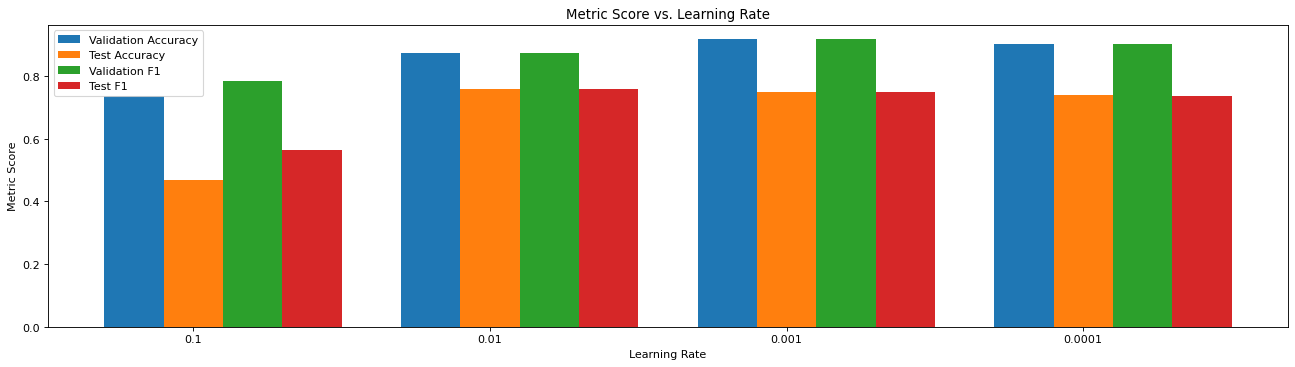

In [61]:
from matplotlib.pyplot import figure

figure(figsize=(20,5), dpi=80)


import numpy as np 
import matplotlib.pyplot as plt 
  
X = lr
val_acc=[0.737,0.8738,0.9183,0.903]
test_acc=[0.4694,0.7594,0.7495,0.7396]
val_f1=[0.785,0.8751,0.918,0.9038]
test_f1=[0.5653,0.7588,0.7497,0.7381]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis -0.2, val_acc, 0.2, label = 'Validation Accuracy')
plt.bar(X_axis, test_acc, 0.2, label = 'Test Accuracy')
plt.bar(X_axis + 0.2, val_f1, 0.2, label = 'Validation F1')
plt.bar(X_axis + 0.4, test_f1, 0.2, label = 'Test F1')

  
plt.xticks(X_axis, X)
plt.xlabel("Learning Rate")
plt.ylabel("Metric Score")
plt.title("Metric Score vs. Learning Rate")
plt.legend()
plt.show()

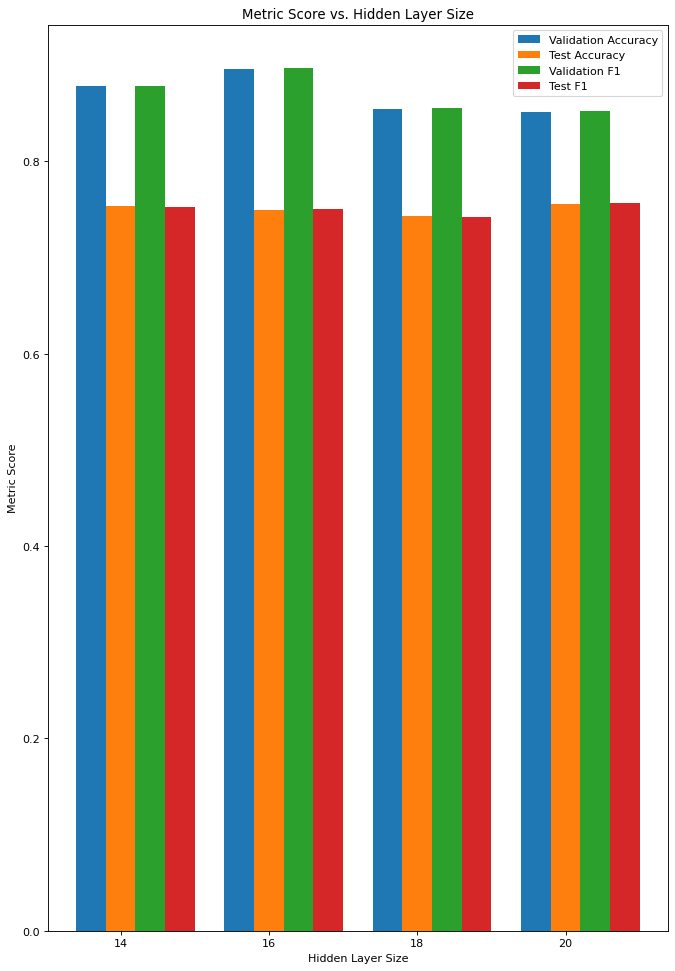

In [42]:
hidden_layer=[14,16,18,20]

from matplotlib.pyplot import figure

figure(figsize=(10,15), dpi=80)


import numpy as np 
import matplotlib.pyplot as plt 
  
X = hidden_layer
val_acc=[0.878713,0.89604,0.85396,0.851485]
test_acc=[0.7535, 0.7495, 0.7436, 0.7554]
val_f1=[0.877819, 0.89704,0.854916,0.852662]
test_f1=[0.7521, 0.7508, 0.7418, 0.7561]

X_axis = np.arange(len(X))
  
plt.bar(X_axis -0.2, val_acc, 0.2, label = 'Validation Accuracy')
plt.bar(X_axis, test_acc, 0.2, label = 'Test Accuracy')
plt.bar(X_axis + 0.2, val_f1, 0.2, label = 'Validation F1')
plt.bar(X_axis + 0.4, test_f1, 0.2, label = 'Test F1')

  
plt.xticks(X_axis, X)
plt.xlabel("Hidden Layer Size")
plt.ylabel("Metric Score")
plt.title("Metric Score vs. Hidden Layer Size")
plt.legend()
plt.show()

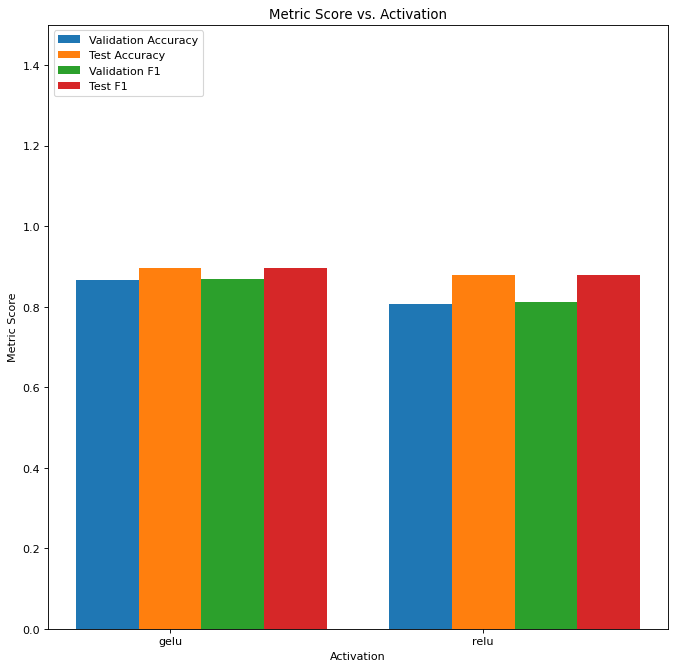

In [53]:
act=["gelu","relu"]

from matplotlib.pyplot import figure

figure(figsize=(10,10), dpi=80)


import numpy as np 
import matplotlib.pyplot as plt 
  
X = act
val_acc=[0.865385,0.807692]
test_acc=[0.8965, 0.8789]
val_f1=[0.867817,0.810328]
test_f1=[0.8965,0.8789]

X_axis = np.arange(len(X))
  
plt.bar(X_axis -0.2, val_acc, 0.2, label = 'Validation Accuracy')
plt.bar(X_axis, test_acc, 0.2, label = 'Test Accuracy')
plt.bar(X_axis + 0.2, val_f1, 0.2, label = 'Validation F1')
plt.bar(X_axis + 0.4, test_f1, 0.2, label = 'Test F1')

plt.ylim(top=1.5)

plt.xticks(X_axis, X)
plt.xlabel("Activation")
plt.ylabel("Metric Score")
plt.title("Metric Score vs. Activation")
plt.legend(loc='upper left')
plt.show()

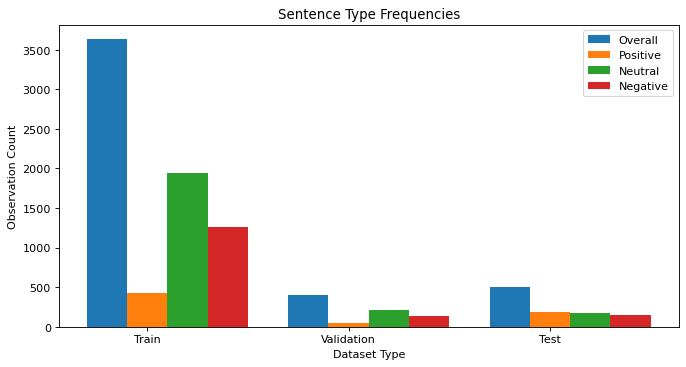

In [60]:
# Counts

act=["Train","Validation","Test"]


from matplotlib.pyplot import figure

figure(figsize=(10,5), dpi=80)


import numpy as np 
import matplotlib.pyplot as plt 
  
X = act
overall=[3633,404,507]
positive=[429,48,186]
neutral=[1948,216,174]
negative=[1256,140,147]

X_axis = np.arange(len(X))
  
plt.bar(X_axis -0.2, overall, 0.2, label = 'Overall')
plt.bar(X_axis, positive, 0.2, label = 'Positive')
plt.bar(X_axis + 0.2, neutral, 0.2, label = 'Neutral')
plt.bar(X_axis + 0.4, negative, 0.2, label = 'Negative')

#plt.ylim(top=1.5)

plt.xticks(X_axis, X)
plt.xlabel("Dataset Type")
plt.ylabel("Observation Count")
plt.title("Sentence Type Frequencies")
plt.legend(loc='upper right')
plt.show()

In [111]:
df_4 = pd.read_csv("data_v4.csv",encoding = "ISO-8859-1")
df_4

,sentence,report section,stock name,label,year,our_result,Ind
0,We serve consumers through our online and phys...,Item 1. Business,AMZN,0,2021,0,1
1,We are guided by four principles: customer obs...,Item 1. Business,AMZN,0,2021,0,1
2,"In each of our segments, we serve our primary ...",Item 1. Business,AMZN,0,2021,0,1
3,"In addition, we provide services, such as adve...",Item 1. Business,AMZN,0,2021,0,1
4,"We seek to offer our customers low prices, fas...",Item 1. Business,AMZN,0,2021,0,1
...,...,...,...,...,...,...,...
502,"Moreover, as additional competitors enter the ...",Item 7. ManagementÕs Discussion and Analysis o...,TSLA,0,2021,1,0
503,The German Umweltbundesamt has issued our subs...,Item 7. ManagementÕs Discussion and Analysis o...,TSLA,-1,2021,0,0
504,We are currently focused on ramping production...,Item 7. ManagementÕs Discussion and Analysis o...,TSLA,0,2021,1,0
505,The Company's management is responsible for th...,Item 8. Financial Statements and Supplementary...,TSLA,0,2021,0,1


In [117]:
from sklearn.metrics import f1_score
df_4 = pd.read_csv("data_v4.csv",encoding = "ISO-8859-1")
df_4=df_4[df_4["label"]==-1]
f1_score(df_4["label"],df_4["our_result"], average='weighted')

0.8947368421052633